## 2018 Data Science Bowl
### Spot Nuclei. Speed Cures.
Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? View this video.

### Why nuclei?
Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

By participating, teams will work to automate the process of identifying nuclei, which will allow for more efficient drug testing, shortening the 10 years it takes for each new drug to come to market. Check out this video overview to find out more.

What will participants do?
Teams will create a computer model that can identify a range of nuclei across varied conditions. By observing patterns, asking questions, and building a model, participants will have a chance to push state-of-the-art technology farther.

Visit DataScienceBowl.com to: 
• Sign up to receive news about the competition
• Learn about the history of the Data Science Bowl and past competitions
• Read our latest insights on emerging analytics techniques

<img src="dsb.jpg"/>

## Data Description
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:

images contains the image file.
masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
The second stage dataset will contain images from unseen experimental conditions. To deter hand labeling, it will also contain images that are ignored in scoring. The metric used to score this competition requires that your submissions are in run-length encoded format. Please see the evaluation page for details.

As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. The dataset will not be updated/re-released unless it is determined that there are a large number of systematic errors. The masks of the stage 1 test set will be released with the release of the stage 2 test set.

### Data Source

you can download data from https://www.kaggle.com/c/data-science-bowl-2018/data

### Code Source

 code for UNet Architecture and Making Predictions copied from the kernel shared by Minggang Chen at https://www.kaggle.com/chenmg04/u-net-for-image-segmentation/notebook
 
 I changed the activation function and Data Loading part using Generator function with ablation.
 for basic UNet Starter you can follow his kernel
 
#### Thanks to Minggang Chen for his work. it speed up my experiments.

## 1. Import libraries

In [23]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf



We set the random seed so that the results don't vary drastically.

In [24]:
np.random.seed(30)
random.seed(30)
tf.set_random_seed(30)

## 2. Explore Data

#### 2.1 Read and Plot Images functions

In [25]:
def read_image_labels(image_id):
    image_file = "Data/stage1_train/{}/images/{}.png".format(image_id,image_id)
    mask_file = "Data/stage1_train/{}/masks/*.png".format(image_id) 
    image = imread(image_file)
    masks = imread_collection(mask_file).concatenate()
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    
    for index in range(0, num_masks):       
        labels = np.maximum(labels, masks[index])
    
    return image, labels

def plot_images_masks(image_ids):
    plt.close('all')
    fig, ax = plt.subplots(nrows=len(image_ids),ncols=2, figsize=(50,50))
    i=0
    for ax_index, image_id in enumerate(image_ids):
        image, labels = read_image_labels(image_id)
        print("image shape:",image.shape)
        ax[i][0].imshow(image)
        ax[i][1].imshow(labels)                 
        i=i+1

    

#### 2.2. Plot some random images with masks

Total Images in Training set: 670
Randomly Selected Images: 2, their IDs: ['d256b32adda37f2301c9e46f34b7f9a36cce273256369ceb5dc2c73c3007e3c4', '6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56']
image shape: (256, 320, 4)
image shape: (256, 320, 4)


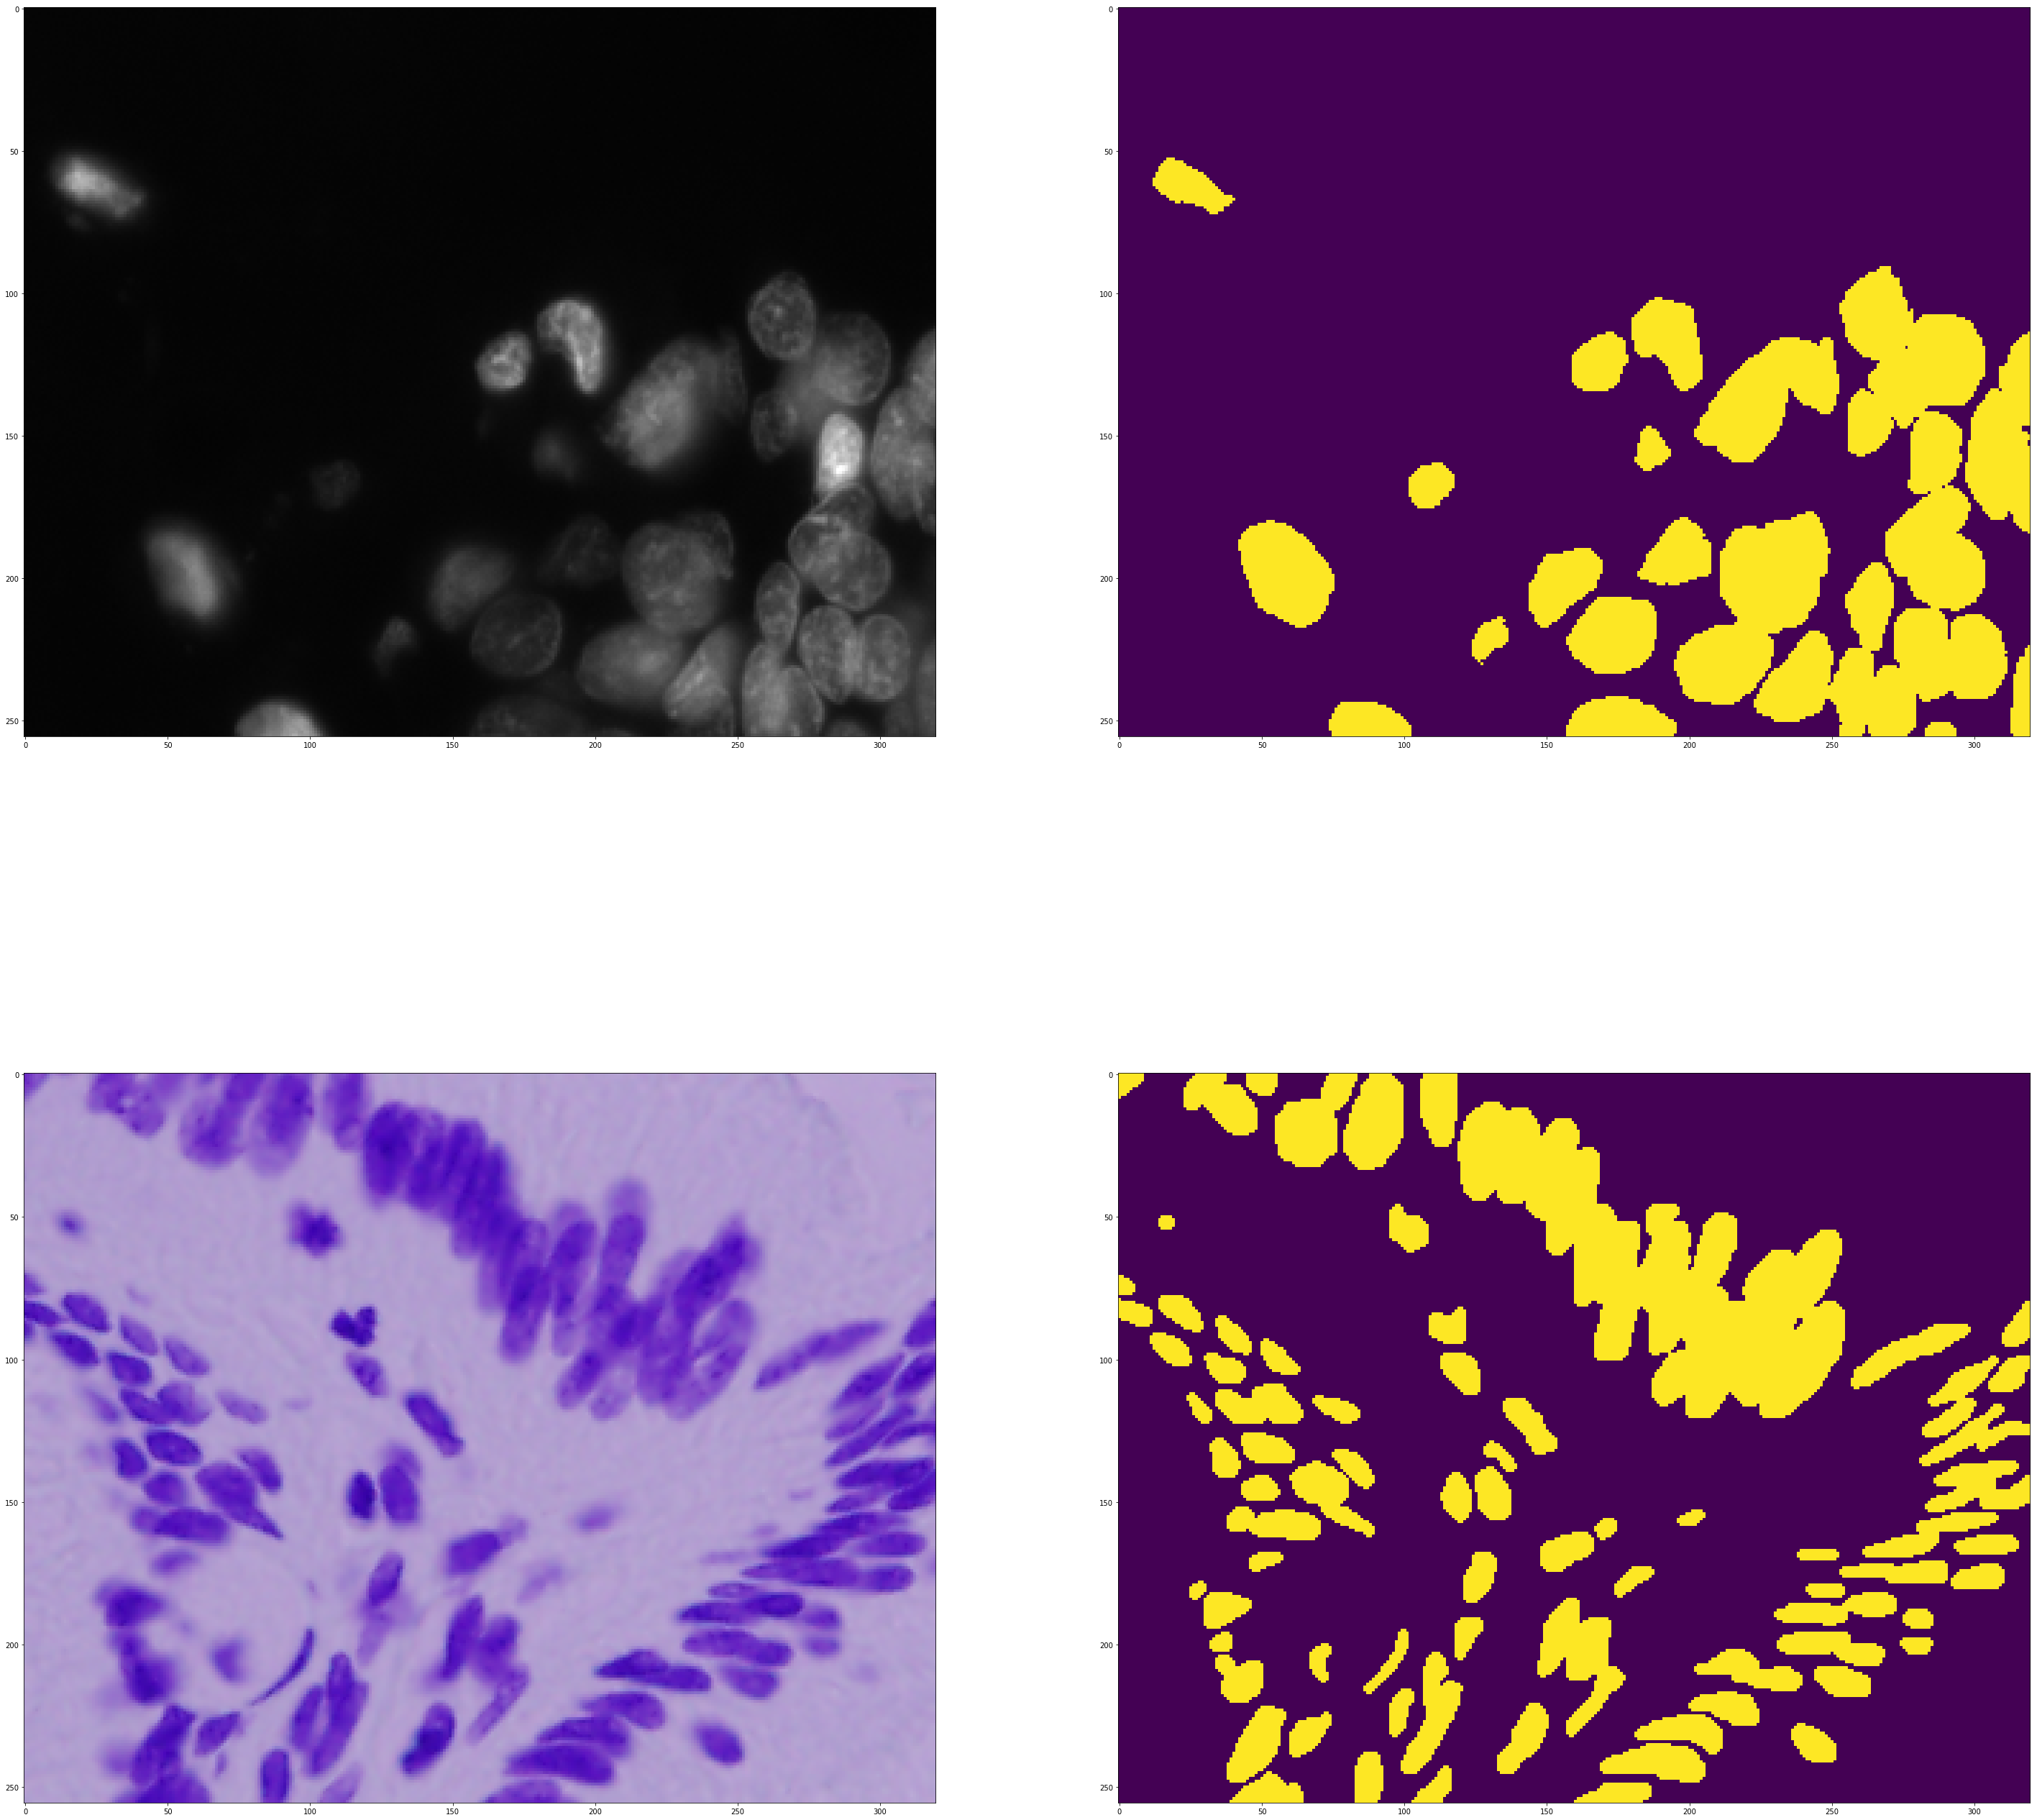

In [26]:
image_ids = os.listdir("Data/stage1_train/")
print("Total Images in Training set: {}".format(len(image_ids)))
random_image_ids = random.sample(image_ids, 2)
print("Randomly Selected Images: {}, their IDs: {}".format(len(random_image_ids), random_image_ids))
plot_images_masks(random_image_ids)

## 3. Data Preprocessing and Data Generator

### 3.1 Data Generator functions

##### Variables Declaration

In [29]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'Data/stage1_train/'
VAL_PATH=TRAIN_PATH
TEST_PATH = "Data/stage2_test/"

##### Read Path for files from inputdata directory

In [30]:
# Get train and test IDs
cellimg_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(cellimg_ids, test_size=0.3)

batch_size = 16 #experiment with the batch size

##### Initialize Batch function

In [31]:
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8) 
    batch_labels = np.zeros((batch_size,IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

##### Function to retrieve data in batach

In [32]:
def get_batchdata(source_path, batch_num, batch_size, batch_ids):
    
    batch_data,batch_labels = init_batch_data(batch_size)      
    #for n, id_ in tqdm(enumerate(batch_ids), total=len(batch_ids)):
    for n, id_ in enumerate(batch_ids):
        path = source_path + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        batch_data[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        batch_labels[n] = mask    
        
    return batch_data,batch_labels

##### Data Generator Function

In [33]:
def generator(source_path, imagefile_ids, batch_size,ablation=None):
    print( 'Source path:{} batch size:{} ablation:{}'.format(source_path,batch_size,ablation))
    #print( 'Source path: ', source_path, ' batch size: ', batch_size,' ablation:',ablation)
    
    if(ablation!=None):
        image_ids=imagefile_ids[:ablation]
    else:
        image_ids=imagefile_ids
            
    while True:
        images = np.random.permutation(image_ids)
        num_batches = len(image_ids)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            #print("\n processing batch:{}".format(batch))
            batch_ids=image_ids[batch*batch_size:(batch*batch_size)+batch_size]
            yield get_batchdata(source_path, batch, batch_size,batch_ids)
            
        
        # Code for the remaining data points which are left after full batches
        if ((len(image_ids)%batch_size) != 0):           
            batch_size_last = len(image_ids) - (batch_size*num_batches)
            batch_ids=image_ids[num_batches*batch_size:(num_batches*batch_size)+batch_size_last]
            yield get_batchdata(source_path, num_batches, batch_size_last, batch_ids) 

##### Calculate Sequences and steps per epoch to disply during training. also create Train and Validation Generator

In [34]:
import datetime
curr_dt_time = datetime.datetime.now()

ablation_train="None"
ablation_test="None"

train_generator = generator(TRAIN_PATH, train_ids, batch_size)
val_generator = generator(VAL_PATH, val_ids, batch_size)

if(ablation_train!="None"):
    num_train_sequences = ablation_train
else:
    num_train_sequences = len(train_ids)
print('# training sequences =', num_train_sequences)

if(ablation_test!="None"):
    num_val_sequences = ablation_test
else:
    num_val_sequences = len(val_ids)
print('# validation sequences =', num_val_sequences)
#------------------------------------------------------
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 469
# validation sequences = 201


Test if Data Generator is working

In [35]:
# batchno=0
# totalrecords=0

# for batch in range(43):
#     batchdata,batchlabel = next(val_generator)
#     totalrecords=totalrecords+len(batchdata)
#     print("batchno:{}".format(batch))
#     print("batchdata:{}".format(len(batchdata)))
#     print("batchlabel:{}".format(len(batchlabel)))
#     print("totalrecords:{}".format(totalrecords))
#     print("------------------------------------")
    
    

## 4. Build Model


##### Define number of epochs

In [36]:
num_epochs =30
print ('# epochs =', num_epochs)

# epochs = 30


##### Define mean iou function for metrics

In [37]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


### Build and train our neural network(U-NET)
Next we build our U-Net model, based on U-Net

<img src="unet.png"/>

### 4.1 Build U-Net Model

In [38]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### 4.2 Compile Model

In [39]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
model.summary()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
_____________________________________________________________________________________

conv2d_15 (Conv2D)              (None, 64, 64, 32)   18464       concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 64, 64, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 32)   9248        dropout_8[0][0]                  
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 128, 128, 16) 2064        conv2d_16[0][0]                  
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128, 128, 32) 0           conv2d_transpose_4[0][0]         
                                                                 conv2d_2[0][0]                   
__________

### 4.3 Define model checkpoints and file name to save model

In [40]:
model_name = 'UNetModels/Trial_meaniou' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{acc:.5f}-{val_loss:.5f}-{val_acc:.5f}.h5'

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [earlystopper, checkpoint, LR]
#callbacks_list = [ checkpoint, LR]

### 4.4 Train the Model
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
Source path:Data/stage1_train/ batch size:16 ablation:None
Source path:Data/stage1_train/ batch size:16 ablation:None
30/30 [==============================] - ETA: 8:05 - loss: 0.6981 - mean_iou: 0.0000e+00 - acc: 0.33 - ETA: 5:39 - loss: 0.7303 - mean_iou: 0.1871 - acc: 0.3572   - ETA: 7:23 - loss: 0.7235 - mean_iou: 0.2544 - acc: 0.45 - ETA: 6:52 - loss: 0.7098 - mean_iou: 0.2895 - acc: 0.52 - ETA: 6:12 - loss: 0.7074 - mean_iou: 0.3116 - acc: 0.57 - ETA: 5:31 - loss: 0.6976 - mean_iou: 0.3261 - acc: 0.61 - ETA: 5:35 - loss: 0.6819 - mean_iou: 0.3369 - acc: 0.64 - ETA: 5:09 - loss: 0.6797 - mean_iou: 0.3457 - acc: 0.65 - ETA: 4:54 - loss: 0.6791 - mean_iou: 0.3521 - acc: 0.66 - ETA: 4:35 - loss: 0.6787 - mean_iou: 0.3567 - acc: 0.67 - ETA: 4:32 - loss: 0.6653 - mean_iou: 0.3603 - acc: 0.68 - ETA: 4:14 - loss: 0.6606 - mean_iou: 0.3636 - acc: 0.69 - ETA: 3:50 - loss: 0.6564 - mean_iou: 0.3665 - acc: 0.70 - ETA: 3:34 - loss: 0.6530 - mean_iou: 0.3690 - acc: 0.71 - ETA: 3:14 

Epoch 00008: val_loss improved from 0.10948 to 0.10440, saving model to UNetModels/Trial_meaniou_2019-04-2411_15_20.348759/model-00008-0.10460-0.96031-0.10440-0.96152.h5
Epoch 9/30
30/30 [==============================] - ETA: 2:16 - loss: 0.1054 - mean_iou: 0.6680 - acc: 0.95 - ETA: 2:54 - loss: 0.0980 - mean_iou: 0.6683 - acc: 0.96 - ETA: 5:33 - loss: 0.1030 - mean_iou: 0.6686 - acc: 0.96 - ETA: 5:34 - loss: 0.1009 - mean_iou: 0.6689 - acc: 0.96 - ETA: 5:11 - loss: 0.1041 - mean_iou: 0.6691 - acc: 0.95 - ETA: 4:45 - loss: 0.1002 - mean_iou: 0.6694 - acc: 0.96 - ETA: 4:58 - loss: 0.1013 - mean_iou: 0.6697 - acc: 0.96 - ETA: 4:34 - loss: 0.1011 - mean_iou: 0.6699 - acc: 0.96 - ETA: 4:26 - loss: 0.1046 - mean_iou: 0.6702 - acc: 0.95 - ETA: 4:09 - loss: 0.1050 - mean_iou: 0.6704 - acc: 0.95 - ETA: 4:08 - loss: 0.1057 - mean_iou: 0.6707 - acc: 0.95 - ETA: 3:53 - loss: 0.1059 - mean_iou: 0.6710 - acc: 0.95 - ETA: 3:33 - loss: 0.1067 - mean_iou: 0.6713 - acc: 0.95 - ETA: 3:19 - loss: 0.1057

30/30 [==============================] - ETA: 2:16 - loss: 0.0864 - mean_iou: 0.7668 - acc: 0.96 - ETA: 2:44 - loss: 0.0803 - mean_iou: 0.7669 - acc: 0.96 - ETA: 5:17 - loss: 0.0829 - mean_iou: 0.7670 - acc: 0.96 - ETA: 5:17 - loss: 0.0819 - mean_iou: 0.7670 - acc: 0.96 - ETA: 4:57 - loss: 0.0846 - mean_iou: 0.7671 - acc: 0.96 - ETA: 4:32 - loss: 0.0818 - mean_iou: 0.7672 - acc: 0.96 - ETA: 4:45 - loss: 0.0827 - mean_iou: 0.7673 - acc: 0.96 - ETA: 4:23 - loss: 0.0820 - mean_iou: 0.7674 - acc: 0.96 - ETA: 4:17 - loss: 0.0853 - mean_iou: 0.7674 - acc: 0.96 - ETA: 4:00 - loss: 0.0857 - mean_iou: 0.7675 - acc: 0.96 - ETA: 4:02 - loss: 0.0859 - mean_iou: 0.7676 - acc: 0.96 - ETA: 3:52 - loss: 0.0863 - mean_iou: 0.7677 - acc: 0.96 - ETA: 3:32 - loss: 0.0870 - mean_iou: 0.7677 - acc: 0.96 - ETA: 3:18 - loss: 0.0862 - mean_iou: 0.7678 - acc: 0.96 - ETA: 3:00 - loss: 0.0861 - mean_iou: 0.7679 - acc: 0.96 - ETA: 2:46 - loss: 0.0855 - mean_iou: 0.7680 - acc: 0.96 - ETA: 2:31 - loss: 0.0862 - mean

30/30 [==============================] - ETA: 2:19 - loss: 0.0792 - mean_iou: 0.8047 - acc: 0.96 - ETA: 2:53 - loss: 0.0745 - mean_iou: 0.8047 - acc: 0.97 - ETA: 5:30 - loss: 0.0749 - mean_iou: 0.8048 - acc: 0.97 - ETA: 5:31 - loss: 0.0729 - mean_iou: 0.8048 - acc: 0.97 - ETA: 5:05 - loss: 0.0758 - mean_iou: 0.8048 - acc: 0.96 - ETA: 4:41 - loss: 0.0738 - mean_iou: 0.8049 - acc: 0.97 - ETA: 4:54 - loss: 0.0747 - mean_iou: 0.8049 - acc: 0.97 - ETA: 4:34 - loss: 0.0739 - mean_iou: 0.8050 - acc: 0.97 - ETA: 4:26 - loss: 0.0768 - mean_iou: 0.8050 - acc: 0.96 - ETA: 4:09 - loss: 0.0777 - mean_iou: 0.8051 - acc: 0.96 - ETA: 4:08 - loss: 0.0772 - mean_iou: 0.8051 - acc: 0.96 - ETA: 3:53 - loss: 0.0775 - mean_iou: 0.8051 - acc: 0.96 - ETA: 3:32 - loss: 0.0785 - mean_iou: 0.8052 - acc: 0.96 - ETA: 3:17 - loss: 0.0779 - mean_iou: 0.8052 - acc: 0.96 - ETA: 2:59 - loss: 0.0780 - mean_iou: 0.8053 - acc: 0.96 - ETA: 2:45 - loss: 0.0772 - mean_iou: 0.8053 - acc: 0.96 - ETA: 2:29 - loss: 0.0775 - mean

## 5. Make predictions

### 5.1 Load Train and Test Data

##### Load train data. you can change this function if you dont want to load all data

In [41]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask




Getting and resizing train images and masks ... 


100%|██████████| 469/469 [03:51<00:00,  3.93s/it]


##### Load Test Data

In [51]:
test_ids[1:10]

['004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf',
 '005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed',
 '005af293e8e53218ae96746ecf9bb88b511154d4a0b35e4ec6296b4623e15836',
 '005d47447abac7f7fa0ac56ba82f13edbf485105baf0672504d84b58d562f38b',
 '00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166',
 '00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83',
 '00da4fe5346bbb36ccf178964a22fdf7e33888989624176a6af3b4a7cfd7da63',
 '00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380bf74985cbe641086806',
 '00e67980783eaae30d41f6479beb9c04eb91de4608537673898039094800ddb0']

In [52]:
print(TEST_PATH)
test_ids_all = next(os.walk(TEST_PATH))[1]
test_ids=test_ids_all[1:10]
print(len(test_ids))

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Data/stage2_test/
9
Getting and resizing test images ... 


100%|██████████| 9/9 [00:00<00:00, 14.99it/s]


Done!


### 5.2 Load Model
##### Replace the modelfile path for the model you want to predict the data with

In [53]:
# # Predict on train, val and test
 model = load_model("UNetModels/Trial_meaniou_2019-04-2411_15_20.348759/model-00023-0.07434-0.97033-0.09049-0.96802.h5", custom_objects={'mean_iou':mean_iou})
 #model = load_model( "UNetModels/Trial_meaniou_2019-04-2315_43_17.237921/model-00015-0.16619-0.93720-0.00013-1.00000.h5", custom_objects={'mean_iou':mean_iou})

##### Predict Cell Segmentation

In [54]:
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

9/9 [==============================] - 1s 121ms/step


##### Plot Random images train image, true label and predicted label

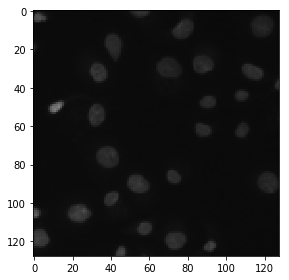

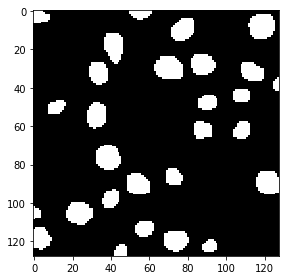

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


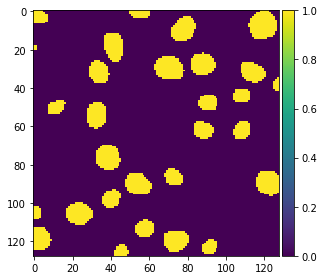

In [55]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

##### Plot Random images test image  predicted label

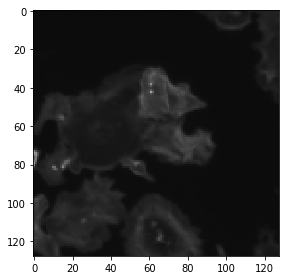

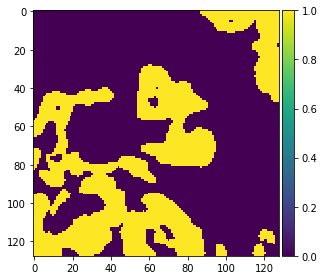

In [56]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()